Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

Init transformation matrices

In [ ]:

def Rx(q):
    T = np.array([[1, 0, 0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q), np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def Ry(q):
    T = np.array([[np.cos(q), 0, np.sin(q), 0],
                  [0, 1, 0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q), np.cos(q), 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]])
    return T


def dRx(q):
    T = np.array([[0, 0, 0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, 0, 0, 0]])
    return T


def dRy(q):
    T = np.array([[-np.sin(q), 0, np.cos(q), 0],
                  [0, 0, 0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [0, 0, 0, 0]])
    return T


def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [np.cos(q), -np.sin(q), 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def dTx(x):
    T = np.array([[0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def dTy(y):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def dTz(z):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]])
    return T

def T_3D(theta_tx, theta_ty, theta_tz, theta_rx, theta_ry, theta_rz):
    return np.linalg.multi_dot([Tx(theta_tx), Ty(theta_ty), Tz(theta_tz), Rx(theta_rx), Ry(theta_ry), Rz(theta_rz)])

Init K-matrices

In [ ]:
def GetK22(E, G, A, Iy, Iz, Ip, link_length):
    K = np.array([[E * A / link_length, 0, 0, 0, 0, 0],
                  [0, 12 * E * Iz / (link_length ** 3), 0, 0, 0, -6 * E * Iz / (link_length ** 2)],
                  [0, 0, 12 * E * Iy / (link_length ** 3), 0, 6 * E * Iy / (link_length ** 2), 0],
                  [0, 0, 0, G * Ip / link_length, 0, 0],
                  [0, 0, 6 * E * Iy / (link_length ** 2), 0, 4 * E * Iy / link_length, 0],
                  [0, -6 * E * Iz / (link_length ** 2), 0, 0, 0, 4 * E * Iz / link_length]])
    return K

Get forward kinematic

In [ ]:
def GetForwardKinematics(base, legs_q_a, legs_q_p, thetas, links):
    legs_fk = []

    for leg in range(len(base)):
        legBase = base[leg]
        leg_q_active = legs_q_a[leg]
        leg_q_passive = legs_q_p[leg]
        leg_theta = thetas[leg]

        T_3D_2_7 = T_3D(leg_theta[1], leg_theta[2], leg_theta[3], leg_theta[4], leg_theta[5], leg_theta[6])
        T_3D_8_13 = T_3D(leg_theta[7], leg_theta[8], leg_theta[9], leg_theta[10], leg_theta[11], leg_theta[12])

        T_leg_local = np.linalg.multi_dot([Tz(leg_q_active[0]),
                                           Tz(leg_theta[0]),
                                           Rz(leg_q_passive[0]),
                                           Tx(links[0]),
                                           T_3D_2_7,
                                           Rz(leg_q_passive[1]),
                                           Tx(links[1]),
                                           T_3D_8_13,
                                           Rz(leg_q_passive[2])])

        T_leg = np.linalg.multi_dot([legBase, T_leg_local])
        legs_fk.append(T_leg)

    return legs_fk

Inverse kinematic

In [ ]:
def getInverseKinematic(leg_bases, platform_edges, links):
    legs_q = []

    for i in range(len(leg_bases)):
        base = leg_bases[i]
        r_base = base[0:3, 0:3]
        p_base = base[0:3, 3]

        xlocal, ylocal, zlocal = np.transpose(r_base).dot(platform_edges[i] - p_base)

        cos_q2 = (xlocal ** 2 + ylocal ** 2 - links[0] ** 2 - links[1] ** 2) / (2 * links[0] * links[1])
        sin_q2 = np.sqrt(1 - cos_q2 ** 2)

        q2 = np.arctan2(sin_q2, cos_q2)
        q1 = np.arctan2(ylocal, xlocal) - np.arctan2(links[1] * np.sin(q2), links[0] + links[1] * np.cos(q2))
        q3 = -(q1 + q2)

        leg_q = np.array([q1, q2, q3])
        legs_q.append(leg_q)

    return legs_q

Get FK for every link

In [ ]:
def getLinkTransformations(base, links, q, theta, ee_pos):
    link_1 = np.linalg.multi_dot([base,
                                     Tz(ee_pos),
                                     # virtual spring
                                     Tz(theta[0]),
                                     Rz(q[0])])
    link_2 = np.linalg.multi_dot([link_1,
                                      Tx(links[0]),
                                      # virtual spring
                                      T_3D(theta[1], theta[2], theta[3], theta[4], theta[5], theta[6]),
                                      Rz(q[1])])

    link_3 = np.linalg.multi_dot([link_2,
                                      Tx(links[1]),
                                      # virtual spring
                                      T_3D(theta[7], theta[8], theta[9], theta[10], theta[11], theta[12]),
                                      Rz(q[2])])
    return link_1, link_2, link_3



Calculate shift from center to platform edges

In [ ]:
def GetPlatformEdges(position):
    posForArmX = [position[0], position[1], position[2]]
    posForArmX[1] += np.sqrt(0.1 ** 2 - 0.05 ** 2)
    posForArmX[0] += 0.05

    posForArmY = [position[0], position[1], position[2]]
    posForArmY[0] -= 0.1

    posForArmZ = [position[0], position[1], position[2]]
    posForArmZ[1] -= np.sqrt(0.1 ** 2 - 0.05 ** 2)
    posForArmZ[0] += 0.05

    return [posForArmX, posForArmY, posForArmZ]

Jacobian

In [ ]:
def getLegJacobian(base, dT_leg_local, inv_FK):
    dT_leg = np.linalg.multi_dot([base, dT_leg_local, inv_FK])
    J = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])
    return J

In [ ]:
def getPassiveLegJacobian(leg_FK, base, q_a, q_p, theta, links):
    leg_FK[0:3, 3] = 0
    inv_FK = np.transpose(leg_FK)

    T_3D_2_7 = T_3D(theta[1], theta[2], theta[3], theta[4], theta[5], theta[6])
    T_3D_8_13 = T_3D(theta[7], theta[8], theta[9], theta[10], theta[11], theta[12])

    dT_leg = np.linalg.multi_dot([Tz(q_a[0]),
                                        Tz(theta[0]),
                                        dRz(q_p[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_p[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_p[2])])
    J1 = getLegJacobian(base, dT_leg, inv_FK)

    dT_leg = np.linalg.multi_dot([Tz(q_a[0]),
                                        Tz(theta[0]),
                                        Rz(q_p[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        dRz(q_p[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_p[2])])

    J2 = getLegJacobian(base, dT_leg, inv_FK)

    dT_leg = np.linalg.multi_dot([Tz(q_a[0]),
                                        Tz(theta[0]),
                                        Rz(q_p[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_p[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        dRz(q_p[2])])

    J3 = getLegJacobian(base, dT_leg, inv_FK)

    J = np.hstack([J1, J2, J3])
    return J

In [ ]:
def GetJacobianForPassive(base, q_active, q_passive, theta, link):
    FK = GetForwardKinematics(base, q_active, q_passive, theta, link)

    Jq = []
    for leg in range(len(base)):
        J = getPassiveLegJacobian(FK[leg], base[leg], q_active[leg], q_passive[leg], theta[leg], link)
        Jq.append(J)
    return Jq

In [ ]:
def GetThetaLegJacobian(FK, base, q_active, q_passive, thetas, links):
    FK[0:3, 3] = 0
    inv_FK = np.transpose(FK)

    T_3D_2_7 = T_3D(thetas[1], thetas[2], thetas[3], thetas[4], thetas[5], thetas[6])
    T_3D_8_13 = T_3D(thetas[7], thetas[8], thetas[9], thetas[10], thetas[11], thetas[12])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        dTz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(thetas[12]),
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK])
    J1 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        dTx(thetas[1]), Ty(thetas[2]), Tz(thetas[3]), Rx(thetas[4]), Ry(thetas[5]), Rz(thetas[6]),
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK])
    J2 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        Tx(thetas[1]), dTy(thetas[2]), Tz(thetas[3]), Rx(thetas[4]), Ry(thetas[5]), Rz(thetas[6]),
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK])
    J3 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        Tx(thetas[1]), Ty(thetas[2]), dTz(thetas[3]), Rx(thetas[4]), Ry(thetas[5]), Rz(thetas[6]),
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK])
    J4 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        Tx(thetas[1]), Ty(thetas[2]), Tz(thetas[3]), dRx(thetas[4]), Ry(thetas[5]), Rz(thetas[6]),
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK])
    J5 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        Tx(thetas[1]), Ty(thetas[2]), Tz(thetas[3]), Rx(thetas[4]), dRy(thetas[5]), Rz(thetas[6]),
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK])
    J6 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        Tx(thetas[1]), Ty(thetas[2]), Tz(thetas[3]), Rx(thetas[4]), Ry(thetas[5]), dRz(thetas[6]),
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        T_3D_8_13,
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK ])
    J7 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        dTx(thetas[7]), Ty(thetas[8]), Tz(thetas[9]), Rx(thetas[10]), Ry(thetas[11]), Rz(thetas[12]),
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK])
    J8 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        Tx(thetas[7]), dTy(thetas[8]), Tz(thetas[9]), Rx(thetas[10]), Ry(thetas[11]), Rz(thetas[12]),
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK  ])
    J9 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        Tx(thetas[7]), Ty(thetas[8]), dTz(thetas[9]), Rx(thetas[10]), Ry(thetas[11]), Rz(thetas[12]),
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK ])
    J10 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        Tx(thetas[7]), Ty(thetas[8]), Tz(thetas[9]), dRx(thetas[10]), Ry(thetas[11]), Rz(thetas[12]),
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK ])
    J11 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        Tx(thetas[7]), Ty(thetas[8]), Tz(thetas[9]), Rx(thetas[10]), dRy(thetas[11]), Rz(thetas[12]),
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK ])
    J12 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg = np.linalg.multi_dot([Tz(q_active[0]),
                                        Tz(thetas[0]),
                                        Rz(q_passive[0]),
                                        Tx(links[0]),
                                        T_3D_2_7,
                                        Rz(q_passive[1]),
                                        Tx(links[1]),
                                        Tx(thetas[7]), Ty(thetas[8]), Tz(thetas[9]), Rx(thetas[10]), Ry(thetas[11]), dRz(thetas[12]),
                                        Rz(q_passive[2])])

    dT_leg = np.linalg.multi_dot([base, dT_leg, inv_FK ])
    J13 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    J = np.hstack([J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11, J12, J13])
    return J

In [ ]:
def GetJacobianForTheta(base, q_active, q_passive, theta, link):
    FK = GetForwardKinematics(base, q_active, q_passive, theta, link)

    Jtheta = []
    for leg in range(len(base)):
        J = GetThetaLegJacobian(FK[leg], base[leg], q_active[leg], q_passive[leg], theta[leg], link)
        Jtheta.append(J)
    return Jtheta

In [ ]:
def KThetaLeg(K_active, E, G, A, Iy, Iz, Ip, link_length):
    K0 = np.zeros(13)
    K0[0] = K_active

    zeros_6_1 = np.zeros((6, 1))
    zeros_6_6 = np.zeros((6, 6))

    K1 = GetK22(E, G, A, Iy, Iz, Ip, link_length)
    K1 = np.hstack([zeros_6_1, K1, zeros_6_6])

    K2 = GetK22(E, G, A, Iy, Iz, Ip, link_length)
    K2 = np.hstack([zeros_6_1, zeros_6_6, K2])

    K = np.vstack([K0, K1, K2])
    return K

Kc calculation

In [ ]:
def GetKc(Ktheta, Jq, Jtheta):
    Kc_total = []
    for i in range(len(Ktheta)):
        Kc0 = np.linalg.inv(np.linalg.multi_dot([Jtheta[i], np.linalg.inv(Ktheta[i]), np.transpose(Jtheta[i])]))
        Kc = Kc0 - np.linalg.multi_dot(
            [Kc0, Jq[i], np.linalg.inv(np.linalg.multi_dot([np.transpose(Jq[i]), Kc0, Jq[i]])), np.transpose(Jq[i]),
             Kc0])
        Kc_total.append(Kc)

    Kc_total = Kc_total[0] + Kc_total[1] + Kc_total[2]
    return Kc_total

In [ ]:
def plotModel(bases, ee_pos, legs_q, legs_theta, link, platform_nodes):
    plt.figure()
    ax = plt.axes(projection='3d')

    ax.set_xlim3d(-0.5, space_size + 0.5)
    ax.set_ylim3d(-0.5, space_size + 0.5)
    ax.set_zlim3d(-0.5, space_size + 0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for i in range(len(bases)):
        q = legs_q[i]
        base = bases[i]

        toPassive1, toPassive2, toPassive3 = getLinkTransformations(base, link, q, legs_theta[i], platform_nodes[i][i])
        link_1 = toPassive1[0:3, 3]
        link_2 = toPassive2[0:3, 3]
        link_3 = toPassive3[0:3, 3]

        # Plot links
        leg = [[], [], []]
        for i in range(len(leg)):
            leg[i].append(link_1[i])
            leg[i].append(link_2[i])
            leg[i].append(link_3[i])

        ax.plot3D(leg[0], leg[1], leg[2], c='indigo', linewidth=2)

        # Plot bases
        active = [[], [], []]
        for i in range(len(leg)):
            active[i].append(base[0:3, 3][i])
            active[i].append(link_1[i])

        ax.plot3D(active[0], active[1], active[2], c='navy', linewidth=3)

    # Plot platform
    for i in range(len(platform_nodes)):
        curNode = platform_nodes[i]
        nextNode = platform_nodes[(i + 1) % len(platform_nodes)]

        x_values = [curNode[0], nextNode[0]]
        y_values = [curNode[1], nextNode[1]]
        z_values = [curNode[2], nextNode[2]]

        plt.plot(x_values, y_values, z_values, color='black', linewidth=2)

    # End-effector pos
    ax.scatter3D(ee_pos[0], ee_pos[1], ee_pos[2], c='red', s=8)


In [ ]:
def plotDeflectionMap(x_pos, y_pos, z_pos, deflection, colormap, s):
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0, space_size)
    ax.set_ylim3d(0, space_size)
    ax.set_zlim3d(0, space_size)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.colorbar(ax.scatter3D(x_pos, y_pos, z_pos, c=deflection, cmap=colormap, s=s))
    plt.show()

In [ ]:
def CalculateDeflections(links, forces):
    x_pos = np.array([])
    y_pos = np.array([])
    z_pos = np.array([])
    deflections = np.array([])

    xlinSpace = np.linspace(0.001, 1, 16)
    ylinSpace = np.linspace(0.001, 1, 16)
    zlinSpace = np.linspace(0.001, 1, 16)

    for x in xlinSpace:
        xData = np.array([])
        yData = np.array([])
        zData = np.array([])
        dData = np.array([])

        for y in ylinSpace:
            for z in zlinSpace:
                ee_pos = np.array([x, y, z])
                q_active = [[ee_pos[0]], [ee_pos[1]], [ee_pos[2]]]
                plt_edges = GetPlatformEdges(ee_pos)
                q_passive = getInverseKinematic(T_base, plt_edges, links)

                Jq = GetJacobianForPassive(T_base, q_active, q_passive, virtual_joints, links)
                Jtheta = GetJacobianForTheta(T_base, q_active, q_passive, virtual_joints, links)

                Kc = GetKc(virtual_k, Jq, Jtheta)

                dt = np.linalg.inv(Kc).dot(forces)
                deflection = np.sqrt(dt[0] ** 2 + dt[1] ** 2 + dt[2] ** 2)

                xData = np.append(xData, x)
                yData = np.append(yData, y)
                zData = np.append(zData, z)
                dData = np.append(dData, deflection)

        x_pos = np.append(x_pos, xData)
        y_pos = np.append(y_pos, yData)
        z_pos = np.append(z_pos, zData)
        deflections = np.append(deflections, dData)

    return x_pos, y_pos, z_pos, deflections

In [ ]:
space_size = 1.0
link_lengths = np.array([1, 1])

T_base_z = np.eye(4)
T_base_y = np.linalg.multi_dot([Tz(space_size), Rx(-np.pi / 2)])
T_base_x = np.linalg.multi_dot([Ty(space_size), Ry(np.pi / 2), Rz(np.pi)])
T_base = [T_base_x, T_base_y, T_base_z]

zeros_mtr = np.zeros(13)
virtual_joints = [zeros_mtr, zeros_mtr, zeros_mtr]

K_active = 1000000

e = 6.9000e+10
g = 2.5500e+10

d_link = 0.15
a = np.pi * (d_link ** 2) / 4
i_y = np.pi * (d_link ** 4) / 64
i_z = np.pi * (d_link ** 4) / 64
i_p = i_y + i_z

virtual_stiffness = KThetaLeg(K_active, e, g, a, i_y, i_z, i_p, link_lengths[0])
virtual_k = [virtual_stiffness, virtual_stiffness, virtual_stiffness]

externalForce = np.array([[0], [0], [100], [0], [0], [0]])

In [ ]:
def Main():
    start = time.time()

    # Plot Tripteron
    p_global = np.array([0.5, 0.5, 0.5])
    p_fake_global = GetPlatformEdges(p_global)
    q_passive = getInverseKinematic(T_base, p_fake_global, link_lengths)

    # Deflections
    xScatter, yScatter, zScatter, dScatter = CalculateDeflections(link_lengths, externalForce)
    end = time.time()

    plotModel(T_base, p_global, q_passive, virtual_joints, link_lengths, p_fake_global)

    clmap = plt.cm.get_cmap('viridis', 12)
    plotDeflectionMap(xScatter, yScatter, zScatter, dScatter, clmap, 60)

    return xScatter, yScatter, zScatter, dScatter, end - start


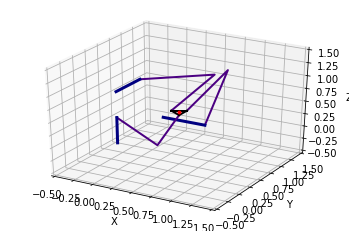

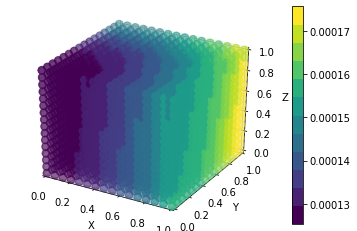

260.2404103279114


In [ ]:
_, _1, _2, _3, time = Main()
print(time)